In [2]:
import pandas as panda
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import seaborn
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
import warnings
import pickle

from joblib import Parallel, delayed
import joblib
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [3]:
dataset = panda.read_csv("HateSpeechData.csv")
dataset

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [4]:
# Adding text-length as a field in the dataset
dataset['text length'] = dataset['tweet'].apply(len)
print(dataset.head())

   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  text length  
0  !!! RT @mayasolovely: As a woman you shouldn't...          140  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...           85  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...          120  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...           62  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...          137  


In [5]:
# collecting only the tweets from the csv file into a variable name tweet
tweet=dataset.tweet

In [6]:
## 1. Removal of punctuation and capitlization
## 2. Tokenizing
## 3. Removal of stopwords
## 4. Stemming

stopwords = nltk.corpus.stopwords.words("english")

#extending the stopwords to include other words used in twitter such as retweet(rt) etc.
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()

def preprocess(tweet):

    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ')

    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '')

    # removal of links[https://abc.com]
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '')

    # removal of punctuations and numbers
    punc_remove = tweets.str.replace("[^a-zA-Z]", " ")
    # remove whitespace with a single space
    newtweet=punc_remove.str.replace(r'\s+', ' ')
    # remove leading and trailing whitespace
    newtweet=newtweet.str.replace(r'^\s+|\s+?$','')
    # replace normal numbers with numbr
    newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')
    # removal of capitalization
    tweet_lower = newtweet.str.lower()

    # tokenizing
    tokenized_tweet = tweet_lower.apply(lambda x: x.split())

    # removal of stopwords
    tokenized_tweet=  tokenized_tweet.apply(lambda x: [item for item in x if item not in stopwords])

    # stemming of the tweets
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        tweets_p= tokenized_tweet

    return tweets_p

processed_tweets = preprocess(tweet)

dataset['processed_tweets'] = processed_tweets
print(dataset[["processed_tweets"]].head(10))

                                    processed_tweets
0  woman complain clean hous amp man alway take t...
1  boy dat cold tyga dwn bad cuffin dat hoe st place
2         dawg ever fuck bitch start cri confus shit
3                                   look like tranni
4     shit hear might true might faker bitch told ya
5      shit blow claim faith somebodi still fuck hoe
6              sit hate anoth bitch got much shit go
7            caus tire big bitch come us skinni girl
8               amp might get ya bitch back amp that
9                    hobbi includ fight mariam bitch


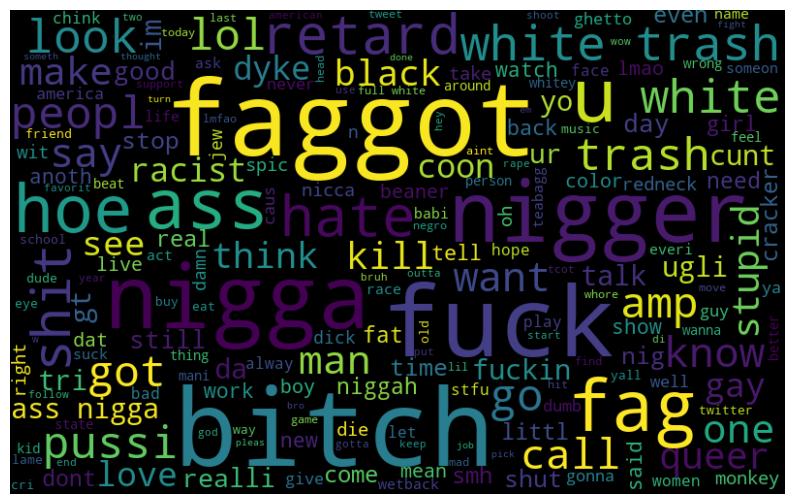

In [7]:
# visualizing which of the word is most commonly used for hatred speech
from wordcloud import WordCloud
import matplotlib.pyplot as plt
hatred_words = ' '.join([text for text in dataset['processed_tweets'][dataset['class'] == 0]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(hatred_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [8]:
#TF-IDF Features-F1
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(dataset['processed_tweets'] )
tfidf

<24783x6441 sparse matrix of type '<class 'numpy.float64'>'
	with 189618 stored elements in Compressed Sparse Row format>

In [9]:
### Written By Bashir
import nltk
nltk.download('vader_lexicon')

#till this part
####
sentiment_analyzer = VS()
def count_tags(tweet_c):

    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', tweet_c)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def sentiment_analysis(tweet):
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    twitter_objs = count_tags(tweet)
    features = [sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],twitter_objs[0], twitter_objs[1],
                twitter_objs[2]]
    #features = pandas.DataFrame(features)
    return features

def sentiment_analysis_array(tweets):
    features=[]
    for t in tweets:
        features.append(sentiment_analysis(t))
    return np.array(features)

#print(tweet)
final_features = sentiment_analysis_array(tweet)
#final_features

new_features = panda.DataFrame({'Neg':final_features[:,0],'Pos':final_features[:,1],'Neu':final_features[:,2],'Compound':final_features[:,3],
                            'url_tag':final_features[:,4],'mention_tag':final_features[:,5],'hash_tag':final_features[:,6]})
new_features

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\bsse1\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Neg,Pos,Neu,Compound,url_tag,mention_tag,hash_tag
0,0.000,0.120,0.880,0.4563,0.0,1.0,0.0
1,0.237,0.000,0.763,-0.6876,0.0,1.0,0.0
2,0.538,0.000,0.462,-0.9550,0.0,2.0,0.0
3,0.000,0.344,0.656,0.5673,0.0,2.0,0.0
4,0.249,0.081,0.669,-0.7762,0.0,1.0,1.0
...,...,...,...,...,...,...,...
24778,0.000,0.000,1.000,0.0000,0.0,3.0,3.0
24779,0.454,0.000,0.546,-0.8074,0.0,0.0,0.0
24780,0.000,0.219,0.781,0.4738,0.0,0.0,0.0
24781,0.573,0.000,0.427,-0.7717,0.0,0.0,0.0


In [10]:
# F2-Conctaenation of tf-idf scores and sentiment scores
tfidf_a = tfidf.toarray()
modelling_features = np.concatenate([tfidf_a,final_features],axis=1)
modelling_features.shape

(24783, 6448)

### Running various model Using TFIDF and additional features

In [11]:
# create doc2vec vector columns
# Initialize and train the model
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
#The input for a Doc2Vec model should be a list of TaggedDocument(['list','of','word'], [TAG_001]).
#A good practice is using the indexes of sentences as the tags.
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(dataset["processed_tweets"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
# window- The maximum distance between the current and predicted word within a sentence.
# mincount-Ignores all words with total frequency lower than this.
# workers -Use these many worker threads to train the model
#  Training Model - distributed bag of words (PV-DBOW) is employed.
model = Doc2Vec(documents,vector_size=5, window=2, min_count=1, workers=4)

#infer_vector - Infer a vector for given post-bulk training document.
# Syntax- infer_vector(doc_words, alpha=None, min_alpha=None, epochs=None, steps=None)
# doc_words-A document for which the vector representation will be inferred.

# transform each document into a vector data
doc2vec_df = dataset["processed_tweets"].apply(lambda x: model.infer_vector(x.split(" "))).apply(panda.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
doc2vec_df

,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
0,-0.086709,-0.049556,0.000457,-0.204879,0.088073
1,0.129553,-0.047043,0.282666,0.065341,-0.070622
2,-0.005200,0.128940,-0.069850,-0.005225,-0.002760
3,-0.040584,0.059393,-0.018060,-0.127576,0.139755
4,-0.080446,0.044097,0.128727,-0.109689,-0.051564
...,...,...,...,...,...
24778,0.297685,0.125751,0.214761,-0.159664,0.197987
24779,0.055618,0.060539,0.144029,0.066215,-0.089867
24780,-0.155624,0.157682,0.115024,0.101689,-0.251179
24781,0.029505,0.126761,0.132686,-0.092595,0.011165


In [12]:
# conctaenation of tf-idf scores, sentiment scores and doc2vec columns
modelling_features = np.concatenate([tfidf_a,final_features,doc2vec_df],axis=1)
modelling_features.shape

(24783, 6453)

Running the models Using TFIDF with additional features from sentiment analysis and doc2vec

In [13]:
#Using TFIDF with sentiment scores,doc2vec and enhanced features
def additional_features(tweet):

    syllables = textstat.syllable_count(tweet)
    num_chars = sum(len(w) for w in tweet)
    num_chars_total = len(tweet)
    num_words = len(tweet.split())
    # avg_syl = total syllables/ total words
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(tweet.split()))

    #  Flesch–Kincaid readability tests are readability tests
    #  designed to indicate how difficult a passage in English is to understand.
    # There are two tests, the Flesch Reading Ease, and the Flesch–Kincaid Grade
    # A text with a comparatively high score on FRE test should have a lower score on the FKRA test.
    # Reference - https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests

    ###Modified FK grade, where avg words per sentence is : just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)

    add_features=[FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_words,
                num_unique_terms]
    return add_features

def get_additonal_feature_array(tweets):
    features=[]
    for t in tweets:
        features.append(additional_features(t))
    return np.array(features)

fFeatures = get_additonal_feature_array(processed_tweets)

In [14]:
tfidf_a = tfidf.toarray()
modelling_features_enhanced = np.concatenate([tfidf_a,final_features,doc2vec_df,fFeatures],axis=1)
modelling_features_enhanced.shape

(24783, 6461)

Combining different features

In [15]:
#f1,f3 and f4 combined

tfidf_a = tfidf.toarray()
modelling_features_one = np.concatenate([tfidf_a,doc2vec_df,fFeatures],axis=1)
modelling_features_one.shape


(24783, 6454)

In [16]:
X = panda.DataFrame(modelling_features_one)
y = dataset['class'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_features,y_train)
y_preds = support.predict(X_test_features)
acc3=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" ,acc3 )

              precision    recall  f1-score   support

           0       0.36      0.01      0.03       279
           1       0.82      0.99      0.90      3852
           2       0.90      0.29      0.44       826

    accuracy                           0.82      4957
   macro avg       0.69      0.43      0.45      4957
weighted avg       0.81      0.82      0.77      4957

SVM, Accuracy Score: 0.820657655840226


p:\spl3\iit_spl3backend_ml\venv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [17]:
#f1,f2 and f4 combined
tfidf_a = tfidf.toarray()
modelling_features_two = np.concatenate([tfidf_a,final_features,fFeatures],axis=1)
modelling_features_two.shape

(24783, 6456)

In [18]:
X = panda.DataFrame(modelling_features_two)
y = dataset['class'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_features,y_train)
y_preds = support.predict(X_test_features)
acc3=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" ,acc3 )

              precision    recall  f1-score   support

           0       0.59      0.09      0.15       279
           1       0.89      0.98      0.93      3852
           2       0.86      0.70      0.77       826

    accuracy                           0.88      4957
   macro avg       0.78      0.59      0.62      4957
weighted avg       0.86      0.88      0.86      4957

SVM, Accuracy Score: 0.8791607827314908


p:\spl3\iit_spl3backend_ml\venv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


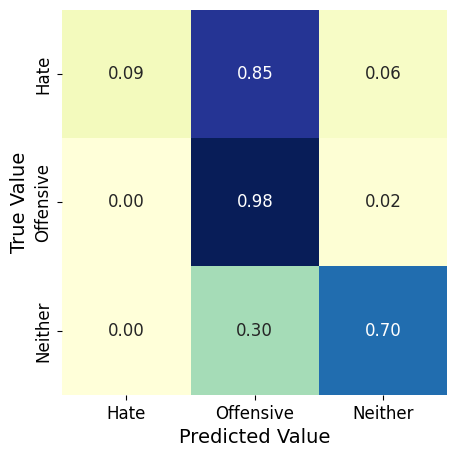

In [19]:
#Confusion Matrix for TFIDF with additional features
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = panda.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

In [20]:
#f2,f3 and f4 combined
modelling_features_three = np.concatenate([final_features,fFeatures],axis=1)
modelling_features_three.shape

(24783, 15)

In [21]:
X = panda.DataFrame(modelling_features_three)
y = dataset['class'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_features,y_train)
y_preds = support.predict(X_test_features)
acc3=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" ,acc3 )

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       279
           1       0.78      1.00      0.88      3852
           2       0.62      0.03      0.06       826

    accuracy                           0.78      4957
   macro avg       0.47      0.34      0.31      4957
weighted avg       0.71      0.78      0.69      4957

SVM, Accuracy Score: 0.7795037320960259


p:\spl3\iit_spl3backend_ml\venv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
p:\spl3\iit_spl3backend_ml\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
p:\spl3\iit_spl3backend_ml\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
p:\spl3\iit_spl3backend_ml\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in 